In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import hyp3_sdk as sdk
import asf_search as asf
import pyproj
import json
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from PIL import Image
from shapely.geometry import Polygon
from config import hyp3_username, hyp3_password
from med_granules import med_granules

In [3]:
sys.path.append('../../SARSearch/src/')
from sarutils import SARUtils

In [ ]:
def merge_landmasks(mask_files, output_file):
    # Open the mask files
    src_files_to_mosaic = [rio.open(mask) for mask in mask_files]
    
    # Merge the masks
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Update the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": src_files_to_mosaic[0].crs,
        "dtype": rasterio.uint8,
        "compress": "lzw"  # Apply compression
    })

    # Write the merged mask to a new file
    with rio.open(output_file, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Close the opened files
    for src in src_files_to_mosaic:
        src.close()

if __name__ == '__main__':
    mask_files = [
        '/home/kai/datasets/W140N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif',
        '/home/kai/datasets/W120N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif',
        '/home/kai/datasets/W140N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif'
    ]
    output_file = '/home/kai/datasets/us_westcoast_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif'
    merge_landmasks(mask_files, output_file)


In [ ]:
sar_frame = '/work/08452/kaipak/ls6/datasets/sarsearch_dev/out_lm/S1A_IW_GRDH_1SDV_20180125T141619_20180125T141644_020312_022B03_CB21_VV_landmask.tif'
sar_frame = '/work/08452/kaipak/ls6/datasets/sarsearch_dev/out_lm/S1A_IW_GRDH_1SDV_20170218T140744_20170218T140809_015339_019272_2A15_VV_landmask.tif'
sar_frame = '/work/08452/kaipak/ls6/datasets/sarsearch_dev/out/vv/S1A_IW_GRDH_1SDV_20170218T140744_20170218T140809_015339_019272_2A15_VV.tif'
sar_frame = '/home1/08452/kaipak/corral-slice/datasets/hyp3_california_30m/dataset/vv/S1A_IW_GRDH_1SDV_20170625T140102_20170625T140127_017191_01CAC5_AAE1_VV.tif'
with rio.open(sar_frame) as scene:
    image_data = scene.read(1)
    no_data_value = scene.nodata
    image_data = np.where(image_data == no_data_value, np.nan, image_data)

In [ ]:
plt.figure(figsize=(50,50))
plt.imshow(image_data, cmap='gray', vmin=np.nanmin(image_data), vmax=np.nanmax(image_data))
plt.colorbar()
plt.title('GeoTIFF Visualization')
plt.show()

In [ ]:
no_data_value

In [ ]:
np.unique(image_data)

In [ ]:
sar_image_path = _4BEC_VV
landcover_tif_path = '/home/kai/datasets/us_westcoast_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif'  # Update with the correct path

# Read the SAR image using rasterio
with rasterio.open(sar_image_path) as src:
    sar_image = src.read(1)  # Read the first band
    no_data_value = src.nodata
    sar_image = np.where(sar_image == no_data_value, np.nan, image_data)
    sar_meta = src.meta
    sar_crs = src.crs
    sar_transform = src.transform
    sar_bounds = src.bounds

# Read the landcover GeoTIFF using rasterio
with rasterio.open(landcover_tif_path) as land_src:
    landcover_data = land_src.read(1)
    land_transform = land_src.transform
    land_bounds = land_src.bounds

# Reproject landcover data if CRS does not match
if sar_crs != land_src.crs:
    from rasterio.warp import reproject, Resampling

    reprojected_landcover_data = np.empty(shape=(sar_meta['height'], sar_meta['width']), dtype=landcover_data.dtype)
    reproject(
        source=landcover_data,
        destination=reprojected_landcover_data,
        src_transform=land_transform,
        src_crs=land_src.crs,
        dst_transform=sar_transform,
        dst_crs=sar_crs,
        resampling=Resampling.nearest
    )
    landcover_data = reprojected_landcover_data

# Define land classes to mask (e.g., water bodies)
# For example, assuming water bodies are represented by value 210 in the landcover data
water_classes = [255]
land_mask = np.isin(landcover_data, water_classes, invert=True)

# Apply the land mask to the SAR image
masked_sar_image = np.where(land_mask, np.nan, sar_image)

# Save the masked SAR image back to a new file
masked_sar_image_path = 'foo.tif'
with rasterio.open(masked_sar_image_path, 'w', **sar_meta) as dst:
    dst.write(masked_sar_image, 1)

# Optional: Plot the original and masked images to verify
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original SAR Image')
plt.imshow(sar_image, cmap='gray', vmin=np.nanmin(sar_image), vmax=np.nanmax(sar_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Masked SAR Image')
plt.imshow(masked_sar_image, cmap='gray', vmin=np.nanmin(masked_sar_image), vmax=np.nanmax(masked_sar_image))
plt.axis('off')

plt.show()


In [ ]:
np.unique(masked_sar_image)

In [ ]:
sns.histplot(vv_data[vv_data > -3 ])

In [ ]:
sns.histplot(vv_data[vv_data < 0][vv_data > -1])


In [ ]:
foo = vv_data[vv_data < 0]

In [ ]:
sns.histplot(foo[foo > -1])

## SARSearch Utils Class for frame processing and dataloader generation


In [34]:
# Provide landmask for area interested in
sarutils = SARUtils(landcover_tif_path='/home/kai/datasets/us_westcoast_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif')

2024-06-05 18:23:53,632 - INFO - GDAL signalled an error: err_no=4, msg='/home/kai/datasets/us_westcoast_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif: No such file or directory'
2024-06-05 18:23:53,634 - ERROR - Error loading landcover data: /home/kai/datasets/us_westcoast_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-proba_EPSG-4326.tif: No such file or directory


### Apply Landmask to directory of GeoTiffs

In [ ]:
# Multiprocess apply landmask to directory of GeoTiffs
sarutils.multiprocess_apply_landmask(input_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv/', 
                                     output_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask/')

## Create an index referencing Frame
Pre-processed index references framename and coordinates of tile. This way, when dataloader needs tiles, it just opens the portion of image needed.

### Ocean tiles, Zero land pixels
`vv_landmask_tile_map_land_0`

In [ ]:
sarutils.index_tiles(tiff_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask/',
                     output_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_0',
                     land_threshold=0)

In [ ]:
sarutils.preview_tiles(index_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_0',
                       tile_size=1000, num_tiles=8)

#### Ocean tiles, up to 50% land pixels
`vv_landmask_tile_map_land_50`

In [ ]:
sarutils.index_tiles(tiff_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask/',
                     output_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_50',
                     land_threshold=.5)

In [ ]:
sarutils.preview_tiles(index_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_50',
                       tile_size=512, num_tiles=5)

### Sliding Window (stride 10%), up to 25% land pixels
`vv_landmask_tile_map_land_str_10pct_lp_25pct`

In [ ]:
sarutils.index_tiles(tiff_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask/',
                     output_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_str_10pct_lp_25pct',
                     land_threshold=.25, stride=1) # separate x/y stride, 

In [ ]:
sarutils.preview_tiles(index_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_str_10pct_lp_25pct',
                       tile_size=512, num_tiles=100)

### Random 100, up to 10% land pixels
`vv_landmask_tile_map_land_random_1k_lp_10pct`

In [ ]:
sarutils.index_tiles(tiff_dir='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask/',
                     output_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_random_100_lp_10pct',
                     random_sampling=True, num_random_samples=2080, tile_size=500, land_threshold=.05)

In [ ]:
sarutils.preview_tiles(index_file='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_random_100_lp_10pct',
                       tile_size=500, num_tiles=5)

In [ ]:
import json

In [ ]:
def get_dataset_len(file_name='/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_str_10pct_lp_25pct'):
    f = open(file_name)
    data = json.load(f)
    
    print(len(data))

In [ ]:
get_dataset_len('/home/kai/datasets/jpl_slice/ben_kai_test/vv_landmask_tile_map_land_str_10pct_lp_25pct')

2024-06-05 22:14:00,841 - INFO - Landmask not provided.


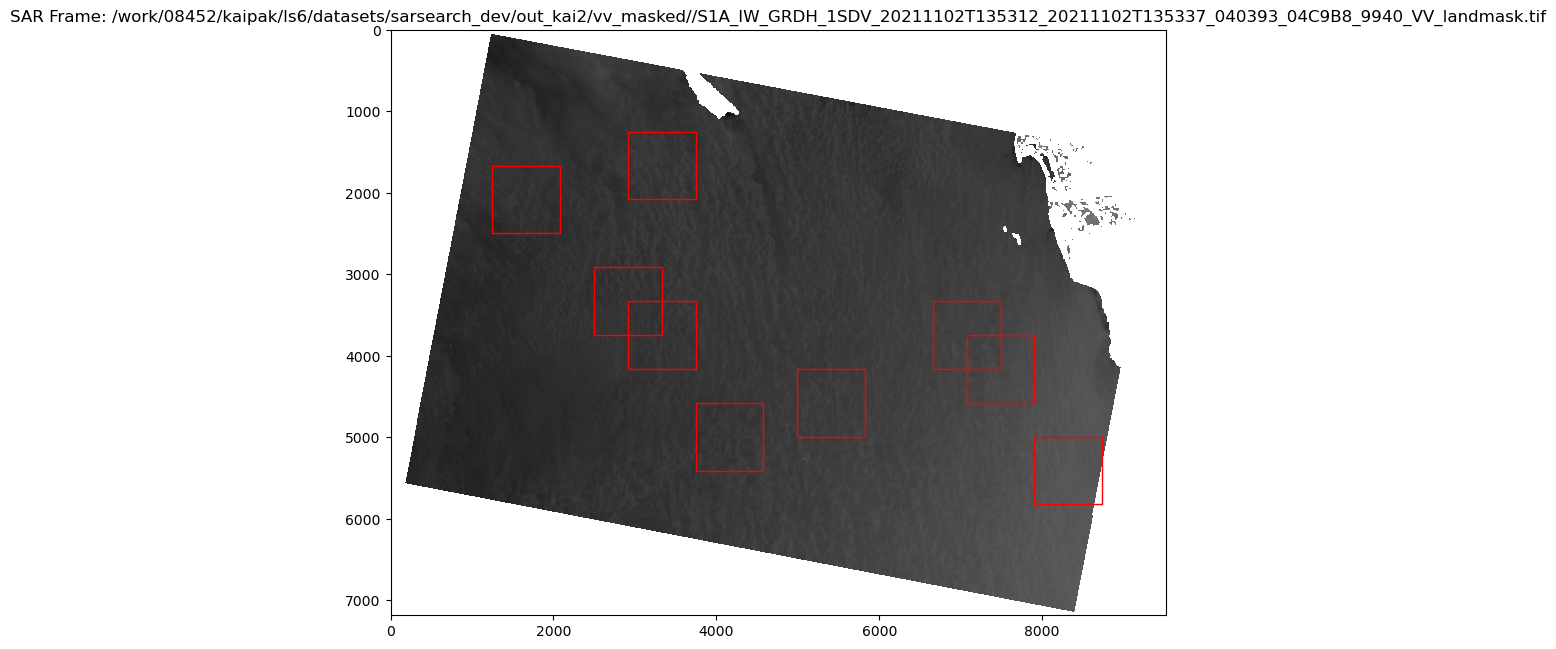

Frame S1A_IW_GRDH_1SDV_20211102T135312_20211102T135337_040393_04C9B8_9940_VV_landmask.tif has 213 tiles.
Selected frame: S1A_IW_GRDH_1SDV_20211102T135312_20211102T135337_040393_04C9B8_9940_VV_landmask.tif


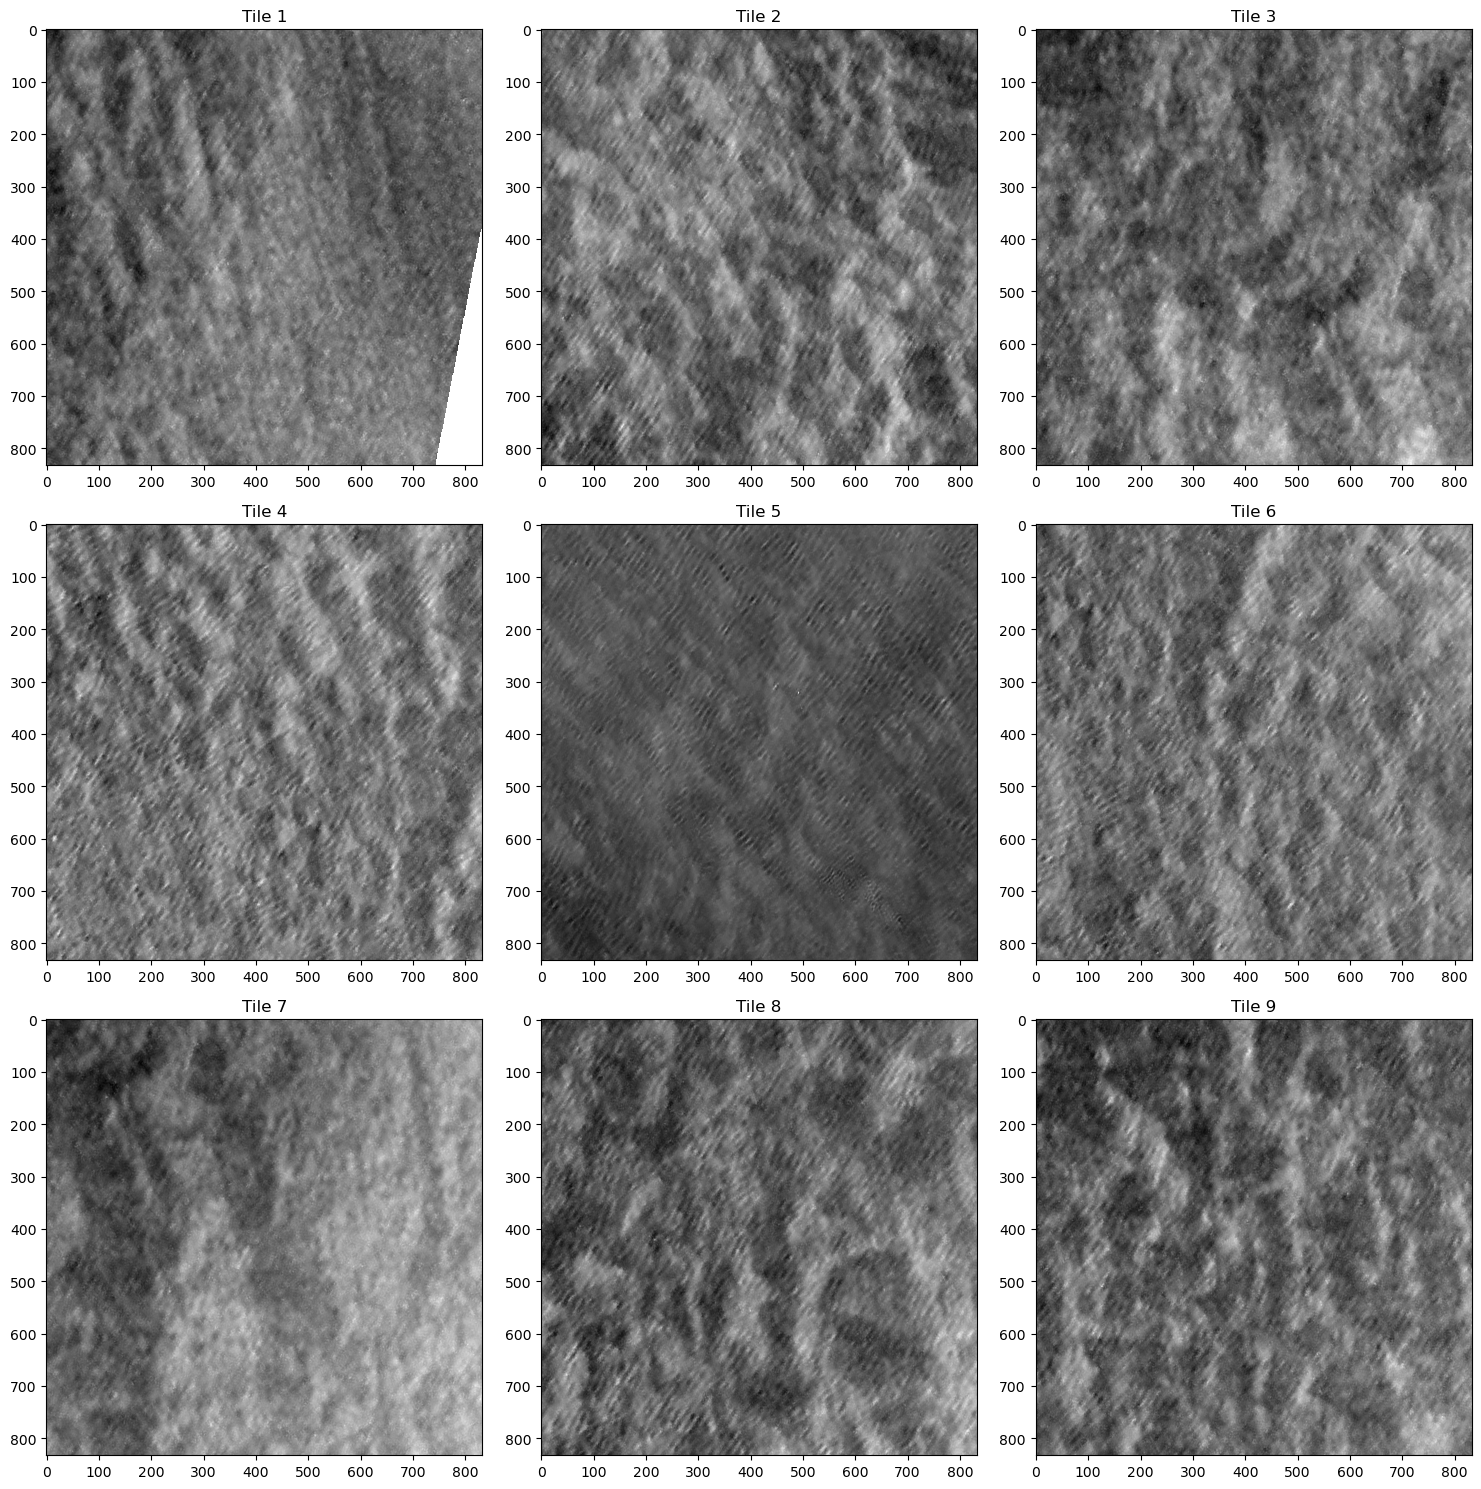

<Figure size 640x480 with 0 Axes>

In [88]:
sarutils = SARUtils()
sarutils.preview_tiles('/work/08452/kaipak/ls6/dev/SARSearch/src/SAR_tile_map.csv')